## Advance Filtering Robotics
We are going to study some state of the art filters and their performance and behaviours in multiple scenarios. In the beginning, we are going to consider linear systems, which are of the form

$$x_{i+1} = Ax_{i} + Bu$$

Where $x_{i}$ is the current state and we can find the next state using the above equation

<br>

Lets consider the following state vector, that we would like to measure and keep track of

$$x = \begin{bmatrix} p \\ v \\ a \end{bmatrix}$$

where $p$ is position, $v$ is velocity, $a$ is acceleration

<br>

The state transition happens in the following way:
$$p_{i+1} = p_{i} * 1 + v_{i} * dt + a * dt^2$$
$$v_{i+1} = p_{i} * 0 + v_{i} * 1 + a * dt$$
$$a_{i+1} = p_{i} * 0 + v_{i} * 0 + a * 1$$

<br>

We can find the transition matrix $A$ from these expressions:

$$A = \begin{bmatrix} 1 & dt & dt^2 \\ 0 & 1 & dt \\ 0 & 0 & 1 \end{bmatrix}$$

<br>

But we also have to consider the control input influence on state transition, which happens in the following way:
$$p_{i+1} = p_{i} * 1 + v_{i} * dt + a * dt^2 + 0$$
$$v_{i+1} = p_{i} * 0 + v_{i} * 1 + a * dt + 0$$
$$a_{i+1} = p_{i} * 0 + v_{i} * 0 + a * 0 + k * u_{T}$$

Here we can observe that only $k * u_{T}$ is added to acceleration, where $u_{T}$ is the Throttle value from the actuator and $k$ maps it into acceleration commands, zeros are added in the position and velocity. The acceleration is also multiplied by $0$ because now the acceleration is coming from the throttle. We can find the $A$ matrix and the control matrix $B$ from these expressions as:

$$A = \begin{bmatrix} 1 & dt & dt^2 \\ 0 & 1 & dt \\ 0 & 0 & 0 \end{bmatrix}$$

$$B = \begin{bmatrix} 0 \\ 0 \\ k \end{bmatrix}$$

<br>

Hence, the full system equation comes out to be:
$$x_{i+1} = Ax_{i} + Bu$$ 
<br>
$$x_{i+1} = \begin{bmatrix} 1 & dt & dt^2 \\ 0 & 1 & dt \\ 0 & 0 & 0 \end{bmatrix}  x_{i} 
+ \begin{bmatrix} 0 \\ 0 \\ k \end{bmatrix}  u_{T}$$

<br>

In short, $A$ is a matrix which maps old state to new state, and $B$ is a matrix that maps the control vector $u$ into a form that can be added in the state vector

## Simulation
Now we will simulate such a linear system, in order to generate data for filtering.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook

<IPython.core.display.Javascript object>


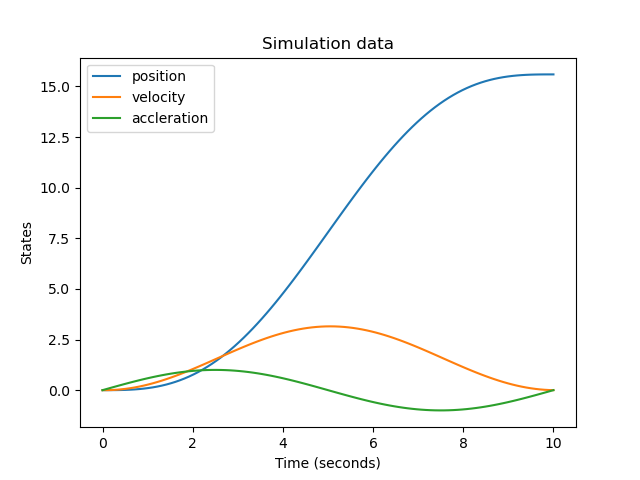

In [4]:
# Total simulation time (seconds)
T = 10

# delta-time (Resolution)
dt = 0.1  # 0.1 seconds

# Number of simulation time-steps
steps = int(T/dt)

# Ground truth states
x_gt = []

# Simulation Time
t = np.linspace(0, T, steps)

# Generating sine-wave acceleration commands
u = np.sin(np.linspace(0, 2*np.pi, steps))

# k value to map throttle to acceleration
k = 1    # k=1 directly maps throttle value to acceleration

# State transition matrix
A = np.array([
    [1, dt, dt**2],
    [0, 1,  dt],
    [0, 0,  0]
])

# Control transition matrix
B = np.array([
    [0],
    [0],
    [k]
])

# Specifying initial state (Starting from [0, 0, 0])
x = np.array([
    [0],
    [0],
    [0]
])

# Simulation loop
for i in range(len(u)):
    x = A@x + B*u[i]
    x_gt.append(x)

# Converting into numpy array
x_gt = np.array(x_gt)

# Plotting the simulation data
plt.figure()
plt.plot(t, x_gt[:, 0], label='position')
plt.plot(t, x_gt[:, 1], label='velocity')
plt.plot(t, x_gt[:, 2], label='accleration')
plt.title('Simulation data')
plt.xlabel('Time (seconds)')
plt.ylabel('States')
plt.legend(loc='best')
plt.show()

## We can generate noisy measurements from this ground-truth simulation data

<IPython.core.display.Javascript object>


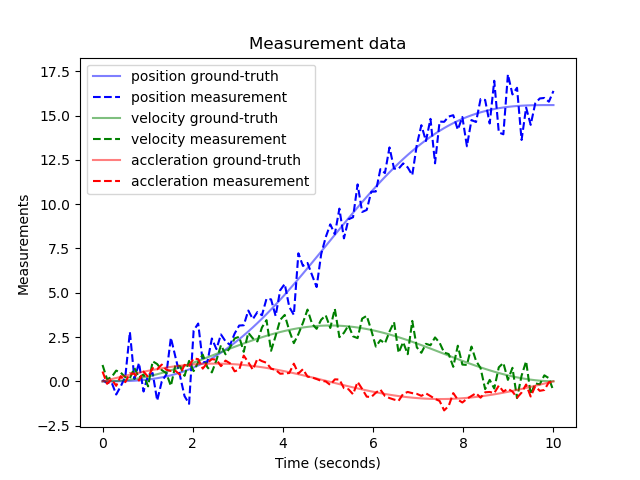

In [5]:
import copy

# copying ground-truth
x_noisy = copy.deepcopy(x_gt)

# Adding gaussian noise
x_noisy[:,0] += np.random.normal(loc=0, scale=1, size=x_noisy.shape[0])[np.newaxis].T
x_noisy[:,1] += np.random.normal(loc=0, scale=0.5, size=x_noisy.shape[0])[np.newaxis].T
x_noisy[:,2] += np.random.normal(loc=0, scale=0.25, size=x_noisy.shape[0])[np.newaxis].T

# Plotting the measurements data
plt.figure()
plt.plot(t, x_gt[:, 0], 'b', label='position ground-truth', alpha=0.5)
plt.plot(t, x_noisy[:, 0], 'b--', label='position measurement')
plt.plot(t, x_gt[:, 1], 'g', label='velocity ground-truth', alpha=0.5)
plt.plot(t, x_noisy[:, 1], 'g--', label='velocity measurement')
plt.plot(t, x_gt[:, 2], 'r', label='accleration ground-truth', alpha=0.5)
plt.plot(t, x_noisy[:, 2], 'r--', label='accleration measurement')
plt.title('Measurement data')
plt.xlabel('Time (seconds)')
plt.ylabel('Measurements')
plt.legend(loc='best')
plt.show()

## Standard Kalman filtering
Now lets filter the above measurement data using a standard kalman filter and compare it to the ground-truth simulation data
Standard kalman filter models the system as a linear system (even when the actual system is non-linear), unfortunately we have to work with the same linear system defined above, but this implementation is practically same to how you would filter a real world system

We have to form an $H$ matrix in order to calculate the difference between the expected measurement and the actual observation. The difference between expectation and measurement is calculated in the following way:
$$Z - Hx$$

Where $H$ is the observation model, $x$ is your extrapolated state and $Z$ is the actual measurement from the sensor. As you can see, $H$ simply transforms your state into a form that can be compared with the sensor measurement.

For the model discussed above, lets say that we can measure the position, velocity and acceleration, then our measurement vector $Z$ would look like 
$$Z = \begin{bmatrix} p_{measured} \\ v_{measured} \\ a_{measured} \end{bmatrix}$$

<br>

If our extrapolated state $x$ is:
$$x_{predicted} = \begin{bmatrix} p_{predicted} \\ v_{predicted} \\ a_{predicted} \end{bmatrix}$$

Then we can choose a matrix $H$ such that is causes corresponding entries to be subtracted when written in $Z-Hx$ form.

Lets say that the $H$ matrix is:
$$H = \begin{bmatrix} 1 && 0 && 0 \\ 0 && 1 && 0 \\ 0 && 0 && 1 \end{bmatrix}$$

Now if we calculate $Hx$, we will actually get the state vector $x$ back. $Hx = x$. Because $H$ is an identity matrix.

Further on, we will look at some other examples, in which we will have to choose this $H$ matrix wisely. But for this particular scenario, this $H$ matrix is the correct observation model.

If you are new to filtering, then you must know that there are some more matrices needed for Kalman filtering, some other important ones are the $Q$ and $R$ matrix. These matrices are the covaraince matrices to represent motion and observation model uncertainity. $Q$ is the motion model uncertainity matrix and $R$ is the observation model uncertainity or measurement covariance matrix. These matrices are usually specified by the user. You must specify these matrices to properly represent the varainces in your motion and sensors.

<IPython.core.display.Javascript object>


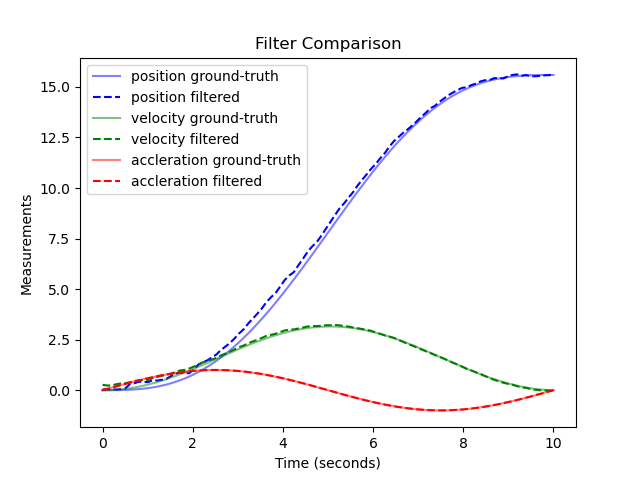

In [6]:
# filtered states
x_filtered = []

# We will use the same A, B, u, k and dt as used in simulation

# In addition, we have to define the observation matrix, that maps the state vector into
# a form that can be compared with the measurements

# Observation matrix
H = np.array([
    [1, 0, 0],  # Position selection
    [0, 1, 0],  # Velocity selection
    [0, 0, 1]   # Acceleration selection
])

# Initial state
x = np.array([
    [0],
    [0],
    [0]
])

# Process covariance (In our case it should be zero, because our control applied during
# simuation had no noisy actuation, but still we will consider some level of process noise
# just for the sake of this implementation)
Q = np.eye(3)           # 3x3 process noise matrix
Q[0, 0] = 0.025 **2     # position variance
Q[1, 1] = 0.0125 **2    # velocity variance
Q[2, 2] = 0.01 **2      # acceleration variance

# Measurement covariance (amount of noise in measured quantities)
R = np.eye(3)       # 3x3 measurement noise matrix
R[0, 0] = 1 **2     # position measurement variance
R[1, 1] = 0.5 **2   # velocity measurement variance
R[2, 2] = 0.25 **2  # acceleration measurement variance

# Initial process covariance (confidence in intial state specified)
P = np.eye(3) * 0.1

# Simulating
for i in range(len(u)):
    
    # ==== PREDICTION STEP ====
    # 1. Extrapolating the state
    x = A@x + B*u[i]  # Ax + Bu
    
    # 2. Extrapolating the process covariance matrix
    P = A@P@A.T + Q
    
    # Getting the noisy measurements from the sensor
    measurement = x_noisy[i, :]
    
    
    # ==== CORRECTION STEP ====
    # 1. Kalman Gain
    K = P@H.T @ np.linalg.inv(H@P@H.T + R)
    
    # 2. Update State Estimate
    x = x + K @ (measurement - H@x)
    
    # 3. Update Estimate Uncertainity
    P = (np.eye(3) - K@H) @ P @ (np.eye(3) - K@H).T + K@R@K.T
    
    # Appending the filtered position to list
    x_filtered.append(x)
    
# Converting to numpy array
x_filtered = np.array(x_filtered)

# Plotting the filter comparison data
plt.figure()
plt.plot(t, x_gt[:, 0], 'b', label='position ground-truth', alpha=0.5)
plt.plot(t, x_filtered[:, 0], 'b--', label='position filtered')
plt.plot(t, x_gt[:, 1], 'g', label='velocity ground-truth', alpha=0.5)
plt.plot(t, x_filtered[:, 1], 'g--', label='velocity filtered')
plt.plot(t, x_gt[:, 2], 'r', label='accleration ground-truth', alpha=0.5)
plt.plot(t, x_filtered[:, 2], 'r--', label='accleration filtered')
plt.title('Filter Comparison')
plt.xlabel('Time (seconds)')
plt.ylabel('Measurements')
plt.legend(loc='best')
plt.show()

## Kalman filtering with non-synchronous sensor measurements
Now we are going to consider a case when our measurements are not synchronous. What would be our observation model matrix $H$ in the case when the measurements for position, velocity and acceleration are coming at different time steps?

Lets find out!

First of all, we have to realize that whenever we are about to perform an update based on a sensor measurement, we need to have the predicted state from the filter for that time-stamp. For example, if a position measurement arrives at time $t$, then we should also have the predicted position at time $t$, so that we can calculate the difference between the two and then update the state vector $x$ using the right $H$ matrix.

There are two steps in Kalman filter ("Prediction" and "Update"). And it should be clear that before every "Update", we must have the "Prediction" from the filter. Hence, we need a modular $A$ matrix, which gives us the prediction at a desired interval. Hence $A$ will not be a constant matrix, instead we will update it inside the loop, based on the time interval between the sensor readings.

Before we proceed any further, firstly we need to construct a list of measurements, that are not synchronized. I will use a dictionary for it.

## Dictionary of (non-synchronized) sensor measurements

In [13]:
measurements = {}

for i in range(x_gt.shape[0]):
    
    # We will take measurements from position, velovity and acceleration successively
    # instead of synchronously now
    
    if i%3 == 0:
        # Position measurement
        measurements[i] = {
            "time": t[i],
            "sensor": "position",
            "measurement": x_gt[i, 0]
        }
        
    if i%3 == 1:
        # Velocity measurement
        measurements[i] = {
            "time": t[i],
            "sensor": "velocity",
            "measurement": x_gt[i, 1]
        }
        
    if i%3 == 2:
        # Acceleration measurement
        measurements[i] = {
            "time": t[i],
            "sensor": "acceleration",
            "measurement": x_gt[i, 2]
        }
        
# Displaying first ten measurements
print("First ten measurements are:\n")
for i in range(10):
    print(measurements[i])

First ten measurements are:

{'time': 0.0, 'sensor': 'position', 'measurement': array([0.])}
{'time': 0.10101010101010101, 'sensor': 'velocity', 'measurement': array([0.])}
{'time': 0.20202020202020202, 'sensor': 'acceleration', 'measurement': array([0.12659245])}
{'time': 0.30303030303030304, 'sensor': 'position', 'measurement': array([0.0025344])}
{'time': 0.40404040404040403, 'sensor': 'velocity', 'measurement': array([0.03792676])}
{'time': 0.5050505050505051, 'sensor': 'acceleration', 'measurement': array([0.31203345])}
{'time': 0.6060606060606061, 'sensor': 'position', 'measurement': array([0.02205573])}
{'time': 0.7070707070707071, 'sensor': 'velocity', 'measurement': array([0.13141115])}
{'time': 0.8080808080808081, 'sensor': 'acceleration', 'measurement': array([0.48619674])}
{'time': 0.9090909090909091, 'sensor': 'position', 'measurement': array([0.07493694])}


Now that we have a dictionary of non-synchronous measurements, we need to treat each measurement differently i.e. we need to have three observation models, one for each sensor. Now, instead of one $H$ matrix, now we will have three matrices $H_{position}$, $H_{velocity}$ and $H_{acceleration}$. Each of these matrices will be responsible for selecting the right entry from the state vector $x$, so as to get subtracted from the measured value.

Now lets create the filter...

<IPython.core.display.Javascript object>


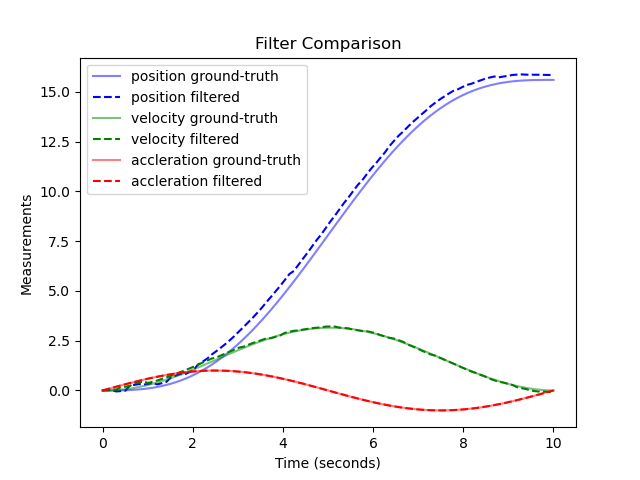

In [34]:
# filtered states
x_filtered = []

# Observation matrices
H_position = np.array([
    [1, 0, 0],      # Position selection
    [0, 0, 0],
    [0, 0, 0]
])

H_velocity = np.array([
    [0, 0, 0],
    [0, 1, 0],      # Velocity selection
    [0, 0, 0]
])

H_acceleration = np.array([
    [0, 0, 0],
    [0, 0, 0],
    [0, 0, 1]       # acceleration selection
])

"""
There are other ways of treating these H matrices as single row matrices, but if we do that, we will have
to adjust the dimensions of other matrices as well, to avoid dimension mis-match errors. For now,
lets be lazy leave them as 3x3 matrices, with non relevant entries changed to zero. In practice, this
is not efficient, it will certainly not cause any observable performance issues, but still we can further
optimize this implementation, if we want to.
"""

# Initial state
x = np.array([
    [0],
    [0],
    [0]
])

# Process covariance (In our case it should be zero, because our control applied during
# simuation had no noisy actuation, but still we will consider some level of process noise
# just for the sake of this implementation)
Q = np.eye(3)           # 3x3 process noise matrix
Q[0, 0] = 0.025 **2     # position variance
Q[1, 1] = 0.0125 **2    # velocity variance
Q[2, 2] = 0.01 **2      # acceleration variance

# Measurement covariance (amount of noise in measured quantities)
R = np.eye(3)       # 3x3 measurement noise matrix
R[0, 0] = 1 **2     # position measurement variance
R[1, 1] = 0.5 **2   # velocity measurement variance
R[2, 2] = 0.25 **2  # acceleration measurement variance

# Initial process covariance (confidence in intial state specified)
P = np.eye(3) * 0.1

# Simulating
prev_time = 0
for i in range(len(u)):
    
    ## A new measurment arrives
    measurement_dict = measurements[i]
    time = measurement_dict['time']         ## Time stamp
    sensor = measurement_dict['sensor']     ## Sensor type
    measurement = measurement_dict['measurement'] ## Measured value
    
    # Time difference between the old and new measurements
    dt = time - prev_time
    
    
    # ==== PREDICTION STEP ====
    # 1. Updating the A matrix based on dt
    A = np.array([
        [1, dt, dt**2],
        [0, 1,  dt],
        [0, 0,  0]
    ])
    
    # 2. Extrapolating the state
    x = A@x + B*u[i]  # Ax + Bu
    
    # 3. Extrapolating the process covariance matrix
    P = A@P@A.T + Q
    
    # Getting the noisy measurements from the sensor
    measurement = x_noisy[i, :]
    
    
    # ==== CORRECTION STEP ====
    
    # 1. Choosing the right observation model, based on sensor type
    if sensor == 'position':
        H = H_position
    elif sensor == 'velocity':
        H = H_velocity
    elif sensor == 'acceleration':
        H = H_acceleration
    else:
        raise NotImplementedError
    
    # 2. Kalman Gain
    K = P@H.T @ np.linalg.inv(H@P@H.T + R)
    
    # 3. Update State Estimate
    x = x + K @ (measurement - H@x)
    
    # 4. Update Estimate Uncertainity
    P = (np.eye(3) - K@H) * P * (np.eye(3) - K@H).T + K@R@K.T
    
    # Appending the filtered position to list
    x_filtered.append(x)
    
    # Updating prev-time
    prev_time = time
    
# Converting to numpy array
x_filtered = np.array(x_filtered)

# Plotting the filter comparison data
plt.figure()
plt.plot(t, x_gt[:, 0], 'b', label='position ground-truth', alpha=0.5)
plt.plot(t, x_filtered[:, 0], 'b--', label='position filtered')
plt.plot(t, x_gt[:, 1], 'g', label='velocity ground-truth', alpha=0.5)
plt.plot(t, x_filtered[:, 1], 'g--', label='velocity filtered')
plt.plot(t, x_gt[:, 2], 'r', label='accleration ground-truth', alpha=0.5)
plt.plot(t, x_filtered[:, 2], 'r--', label='accleration filtered')
plt.title('Filter Comparison')
plt.xlabel('Time (seconds)')
plt.ylabel('Measurements')
plt.legend(loc='best')
plt.show()

## TODO Next : Filters with switching motion and observation models
I would like to discuss and explain filters that have switching observation and measurement models. In real world, the observation and measurement models are not static. They can change depending upon the state of the system. For example, your sensor is working normally on a sunny day, and is in nominal working conditions, but on a rainy day, it performs differently. Or lets say, that your car is running in nominal conditions usually, but if one of its tyres is flat, then suddenly your actual motion model of the system is changed. Or lets say that your sensor has failed completely and is giving no output.
To detect and cater for such scenarios, in your filter, you have to account for multiple motion and observation models. And you can switch between them, to have a better estimate, as well as you can detect these failures.

We will also cover some filters for non-linear and non-holonomic systems moving in multiple dimensions (in future). Sorry, but you will have to wait for further implementations here, so stay tuned.
And if you like my work, you can support it by giving it a star and following me on github. It would be great if you check out my other repositories as well, and maybe star them too if you happen to like them. Thankyou :)

The ones who are curious can explore the following topics meanwhile:
- Switching Kalman Filters
- Change point detection
- Particle Filters